<a href="https://colab.research.google.com/github/EVikVik/60daysofudacity/blob/master/FaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import re
import time
import random
import os
import cv2
import pandas as pd
import torchvision
import numpy as np
from PIL import Image
import torch.nn.init as init
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision import models, datasets, transforms
from torch.optim import Adam, SGD, RMSprop
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [0]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(1234)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(112, 92)


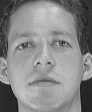

In [0]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/drive/My Drive/Siamese/orl_faces.zip (Unzipped Files)/orl_faces/s1/7.pgm')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(img.shape)
cv2_imshow(img)

112 112


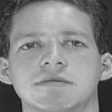

In [0]:
#get the dimensions
img = cv2.resize(img, (112,112))
dim1 = img.shape[0]
dim2 = img.shape[1]
print(dim1, dim2)
cv2_imshow(img)

In [0]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = cv2.imread('/content/drive/My Drive/Siamese/orl_faces.zip (Unzipped Files)/orl_faces/s' + str(1) + '/' + str(1) + '.pgm')
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = cv2.imread('/content/drive/My Drive/Siamese/orl_faces.zip (Unzipped Files)/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm')
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
            img1 = np.uint8(img1)
            img2 = cv2.imread('/content/drive/My Drive/Siamese/orl_faces.zip (Unzipped Files)/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm')
            img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
            img2 = np.uint8(img2)
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0,  :, :] = img1
            x_geuine_pair[count, 1,  :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = cv2.imread('/content/drive/My Drive/Siamese/orl_faces.zip (Unzipped Files)/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm')
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
            img1 = np.uint8(img1)
            img2 = cv2.imread('/content/drive/My Drive/Siamese/orl_faces.zip (Unzipped Files)/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm')
            img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
            img2 = np.uint8(img2)

            x_imposite_pair[count, 0, :, :] = img1
            x_imposite_pair[count, 1, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [0]:
del X
del Y

In [0]:
X, Y = get_data(size, total_sample_size)

In [0]:
print(X.shape)
Y.shape

(20000, 2, 112, 92)


(20000, 1)

(112, 92)


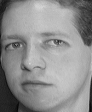

In [0]:
from google.colab.patches import cv2_imshow
print(X[0][0].shape)
cv2_imshow(X[0][0])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

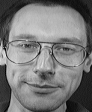

In [0]:
cv2_imshow(X_train[0][1])

In [0]:
len(X_train)

15000

In [0]:
class SiameseNetworkDataset():
    
    def __init__(self,image_list,labels_list, transform=None):
        # used to prepare the labels and images path
        self.image_list= image_list
        self.labels_list = labels_list   
        self.transform = transform

    def __getitem__(self,idx):
        ## getting the image path
        ## Loading the image
        img0 = self.image_list[idx][0]
        img0 = cv2.resize(img0, (105,105))
        img1 = self.image_list[idx][1]
        img1 = cv2.resize(img1, (105,105))
        label = self.labels_list[idx]
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img1, img0 , torch.from_numpy(np.array(label, dtype = np.float32))
    
    def __len__(self):
        return len(self.image_list)

In [0]:
siamese_dataset = SiameseNetworkDataset(X_train, y_train,
                                        transform=transforms.Compose([transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(siamese_dataset, batch_size=32, shuffle=True)

batch = next(iter(trainloader))

In [0]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    cv2_imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [0]:
len(trainloader)

469

In [0]:
batch[2]

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

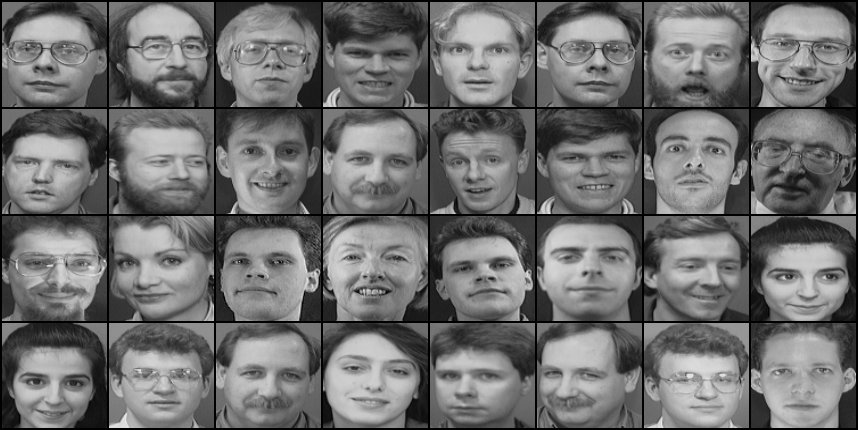

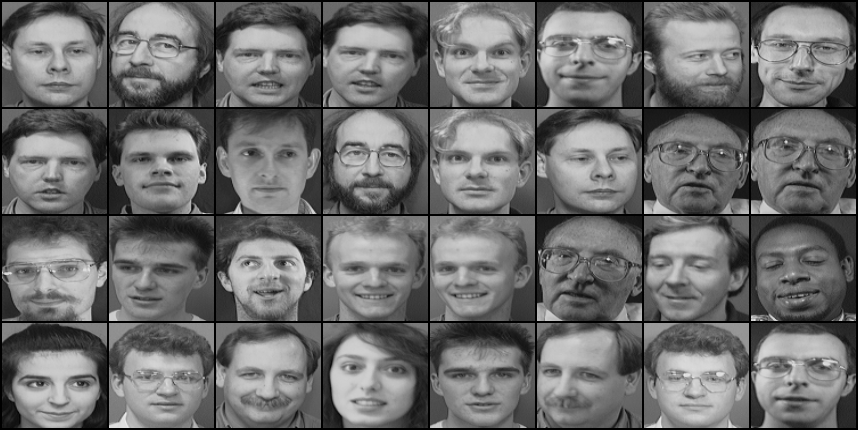

In [0]:
show_batch(batch[0])
show_batch(batch[1])

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384, kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [0]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = RMSprop(net.parameters(), lr=1e-3, alpha=0.99, eps=1e-8, weight_decay=0.005, momentum=0.9)

In [0]:
class Config():
    train_batch_size = 32
    train_number_epochs = 10

In [0]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(trainloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.to('cuda', dtype = torch.float) , img1.to('cuda', dtype = torch.float) , label.to('cuda', dtype = torch.float)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()

Epoch number 0
 Current loss 1.6127561330795288

Epoch number 0
 Current loss 1.1022210121154785

Epoch number 0
 Current loss 1.234136700630188

Epoch number 0
 Current loss 1.2418419122695923

Epoch number 0
 Current loss 1.0729312896728516

Epoch number 0
 Current loss 1.2809131145477295

Epoch number 0
 Current loss 1.111429214477539

Epoch number 0
 Current loss 1.0954020023345947

Epoch number 0
 Current loss 1.3373204469680786

Epoch number 0
 Current loss 1.202178955078125

Epoch number 1
 Current loss 1.3712416887283325

Epoch number 1
 Current loss 1.1203765869140625



KeyboardInterrupt: ignored